# CS909/CS429 Data Mining 2025 Assignment 1: Classification

**GAIT decleration**

I have used AI tools to assist in structuring my code and quickly producing repetitive code like subplot layouts etc. The intention behind its use was to enchance clarity through checking comments, ensuring correctness and improving efficiency while maintaining academic integrity.

### Importing Relevant Modules:

In [4]:
import random
import time
import math
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import rotate

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score,
    average_precision_score, f1_score, matthews_corrcoef, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV


# Question No. 1: (Exploring data) [10% Marks]

## Q1 i) a)

In [7]:

xtrain = np.loadtxt("Xtrain.csv", delimiter=" ")
ytrain = np.loadtxt("Ytrain.csv", delimiter=" ")
xtest = np.loadtxt("Xtest.csv", delimiter=" ")


class1count = np.count_nonzero(ytrain == 1)
class2count = np.count_nonzero(ytrain == -1)
print("There are",class1count, "images of class 1 (+1)")
print("And",class2count, "images of class 2 (-1)")
print("We cannot know the number of images in different classes in the Xtest data, since we have not been given the data labels!")

There are 614 images of class 1 (+1)
And 2386 images of class 2 (-1)
We cannot know the number of images in different classes in the Xtest data, since we have not been given the data labels!


## Q1 i) b)

The results indicate a significant class imbalance, with the -1 class being much more prevalent. This imbalance could pose challenges for training our machine learning model, as many models might become biased toward the majority class, leading to poor performance on the minority class.

## Q1 ii) a)

### Code: 

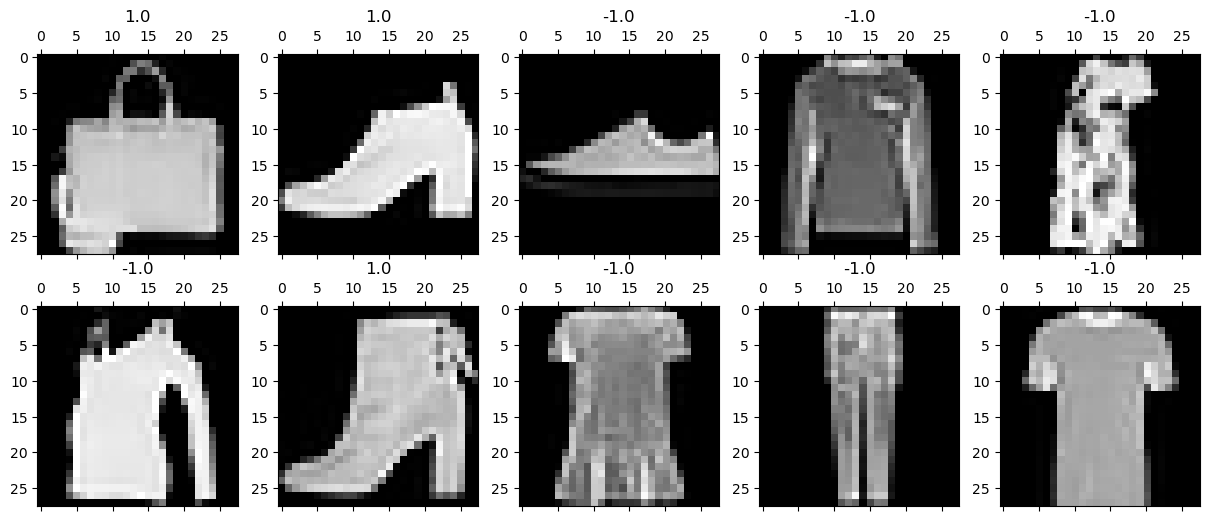

In [12]:
#creating array of random image locations
rndlocs = [random.randint(0,3000) for _ in range(10)]

#creating grid for plotting
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

#counters to reduce code length
xcount = 0
ycount = 0


#looping through list of random locations
for locs in rndlocs:
    
    if xcount == 5:
        ycount += 1
        xcount = 0
        
    #reshaping image and plotting
    img = xtrain[locs]
    img = img.reshape(28, 28)
    axs[ycount,xcount].matshow(img,cmap='gray', vmin=0, vmax=255)
    axs[ycount,xcount].set_title(ytrain[locs])
    xcount += 1

plt.show()

### Discussion:

The images appear to be a variety of items of clothing and footwear. One immediate observation is that all the images seem to be taken from a similar angle, in that they are all aligned vertically. I also noticed that any images of boots and bags seem to be in the +1 class.

## Q1 ii) b)

### Code:

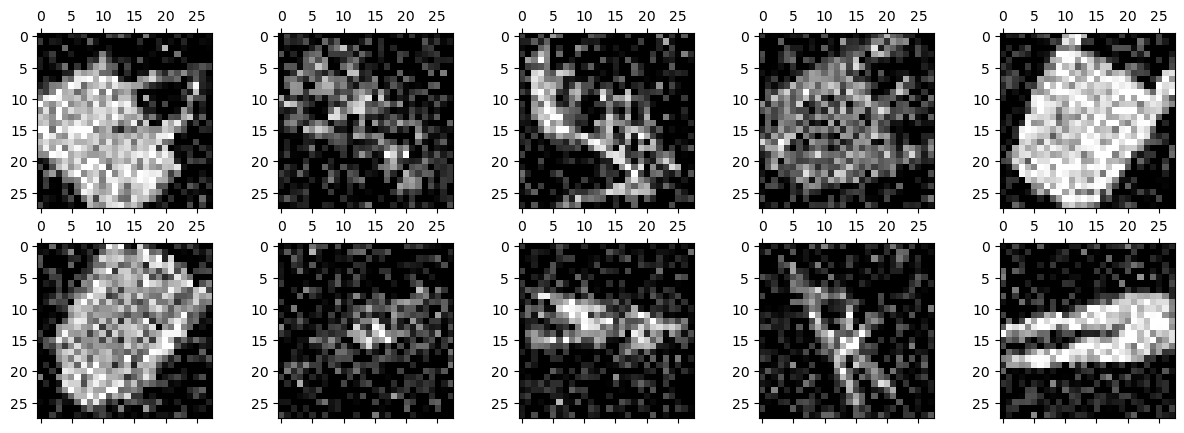

In [17]:
#creating array of random image locations
rndlocs = [random.randint(0,3000) for _ in range(10)]

#creating grid for plotting
fig, axs = plt.subplots(2, 5, figsize=(15, 5))

#counters to reduce code length
xcount = 0
ycount = 0


#looping through list of random locations
for locs in rndlocs:
    
    if xcount == 5:
        ycount += 1
        xcount = 0
        
    #reshaping image and plotting testing images
    img = xtest[locs]
    img = img.reshape(28, 28)
    axs[ycount,xcount].matshow(img,cmap='gray', vmin=0, vmax=255)
    xcount += 1

plt.show()

### Discussion:

We notice that the test data is significantly more grainy and blurry than the training data. This will cause issues as the classifier will be trained on clean(er) data, so will struggle to identify features and generalize in the grainy test data.

We also notice that all of the test images seem to be at slighly different orientations, with some heavily tilted off centre. This in contrast to our training data, which is all nearly perfectly vertically aligned. This may cause issues with our classifier if it is not orientation invariant.

## Q1 iii)

Since we have a **highly imbalanced** dataset, I would argue that AUC-PR is the best metric for this task. This is because AUC-PR emphasises how well the model performes on the minority class, which is vital in this case since we have an approximately 80-20 split of images by class.

In all the below definitions: 
- TP stands for the #true positives
- FP for the #false positives
- TN stands for the #true negatives
- FN stands for the #false negatives

$$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$

**AUC-ROC** is the area under the graph when you plot TPR as a function fo FPR, where $$ TPR = \frac{TP}{TP + FN}  $$ and $$ FPR = \frac{FP}{FP + TN} $$


**AUC-PR** is the area under the graph when you plot precision as a function of TPR, where TPR is defined above and $$ precision = \frac{TP}{TP + FP} $$

$$ F1 = 2 \times \frac{Precision \times TPR}{Precision +  TPR} $$

$$ \text{Matthews Correction Coefficient} = \frac{(TP \times TN) - (FP \times FN)}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

$$ \text{Mean Squared Error} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2$$

where:
- $N$ is the total number of samples,
- $\hat{y}_i$ is the predicted value for the $i$-th sample,
- $y_i$ is the actual value for the $i$-th sample.

## Q1 iv)

We would expect it to achieve an accuracy of 0.5 on both training and test datasets (assuming an identitical distribution)

In [30]:
# Create a random classifier that outputs random scores in range [-1, +1]
def random_classifier_predictions(num_samples):
    return np.random.uniform(-1, 1, num_samples)

# Define class distribution for the training set (80% -1, 20% +1)
train_size = len(xtrain)
test_size = len(xtest)

y_train_random = np.random.choice([-1, 1], size=train_size, p=[0.8, 0.2])  # Reflecting class imbalance in train set

# Generate random classifier predictions
y_train_pred = random_classifier_predictions(train_size)

# Compute accuracy of a random classifier
random_train_accuracy = accuracy_score(y_train_random, np.sign(y_train_pred))


print(f"Random Classifier Accuracy on Training Set: {random_train_accuracy:.4f}")

Random Classifier Accuracy on Training Set: 0.5003


## Q1 v)

*AUC-ROC:*
- The expected AUC-ROC for a random classifier remains around **0.5**, meaning it performs no better than chance.
- This metric is unaffected by class imbalance since it measures how well the model ranks positive vs. negative samples.

*AUC-PR:*
- AUC-PR is sensitive to class imbalance. Since only **20% of the training data is in class +1**, a random classifier would have a lower AUC-PR than AUC-ROC.
- A random classifier should achieve an AUC-PR close to the proportion of the positive class (0.20).

In [33]:
# Compute AUC-ROC and AUC-PR for a random classifier
auc_roc_train = roc_auc_score(y_train_random, y_train_pred)
auc_pr_train = average_precision_score(y_train_random, y_train_pred)

print(f"Random Classifier AUC-ROC on Training Set: {auc_roc_train:.4f}")
print(f"Random Classifier AUC-PR on Training Set: {auc_pr_train:.4f}")

Random Classifier AUC-ROC on Training Set: 0.5104
Random Classifier AUC-PR on Training Set: 0.2049


*Consequences*

- If a trained model achieves **AUC-ROC ≈ 0.5**, it has no meaningful predictive power.
- If AUC-PR is **close to 0.20**, it indicates that the classifier is performing at the level of random chance given class imbalance.
- This highlights the importance of using **both AUC-ROC and AUC-PR** to evaluate models, especially in imbalanced datasets.

# Question No. 2: (Nearest Neighbor Classifier) [10% Marks]

## Q2 i)

In [37]:
# Define 5-fold stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

# Initialize performance metric storage
metrics = {
    "Accuracy": [],
    "Balanced Accuracy": [],
    "AUC-ROC": [],
    "AUC-PR": [],
    "F1 Score": [],
    "MCC": []
}

# Store trained models and predictions for reuse
knn_models = []  # Store trained kNN models
test_sets = []   # Store (y_test, y_proba) pairs

# Perform cross-validation on training images
for train_idx, test_idx in skf.split(xtrain, ytrain):
    x_train, x_test = xtrain[train_idx], xtrain[test_idx]
    y_train, y_test = ytrain[train_idx], ytrain[test_idx]

    # Train kNN classifier with k=5
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(x_train, y_train)

    # Make predictions
    y_pred = knn.predict(x_test)
    y_proba = knn.predict_proba(x_test)[:, 1]  # Probabilities for class +1

    # Compute metrics
    metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["Balanced Accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    metrics["AUC-ROC"].append(roc_auc_score(y_test, y_proba))
    metrics["AUC-PR"].append(average_precision_score(y_test, y_proba))
    metrics["F1 Score"].append(f1_score(y_test, y_pred))
    metrics["MCC"].append(matthews_corrcoef(y_test, y_pred))

    # Store model and test data for use in part ii
    knn_models.append(knn)
    test_sets.append((y_test, y_proba))

# Convert metrics to a dataframe structure
metrics_df = pd.DataFrame(metrics)

# Compute mean and standard deviation for each metric
metrics_df.loc["Mean"] = metrics_df.mean()
metrics_df.loc["Std Dev"] = metrics_df.std()

# Print the table of metric results
print(metrics_df)


         Accuracy  Balanced Accuracy   AUC-ROC    AUC-PR  F1 Score       MCC
0        0.951667           0.920828  0.951643  0.878783  0.879668  0.849537
1        0.966667           0.951884  0.980220  0.962385  0.919355  0.898395
2        0.956667           0.927494  0.975985  0.931684  0.892562  0.865617
3        0.968333           0.946899  0.970718  0.935500  0.921811  0.902069
4        0.966667           0.948867  0.979266  0.953808  0.918699  0.897735
Mean     0.962000           0.939194  0.971566  0.932432  0.906419  0.882670
Std Dev  0.006616           0.012555  0.010501  0.029128  0.017104  0.021162


## Q2 ii)

### Code: 

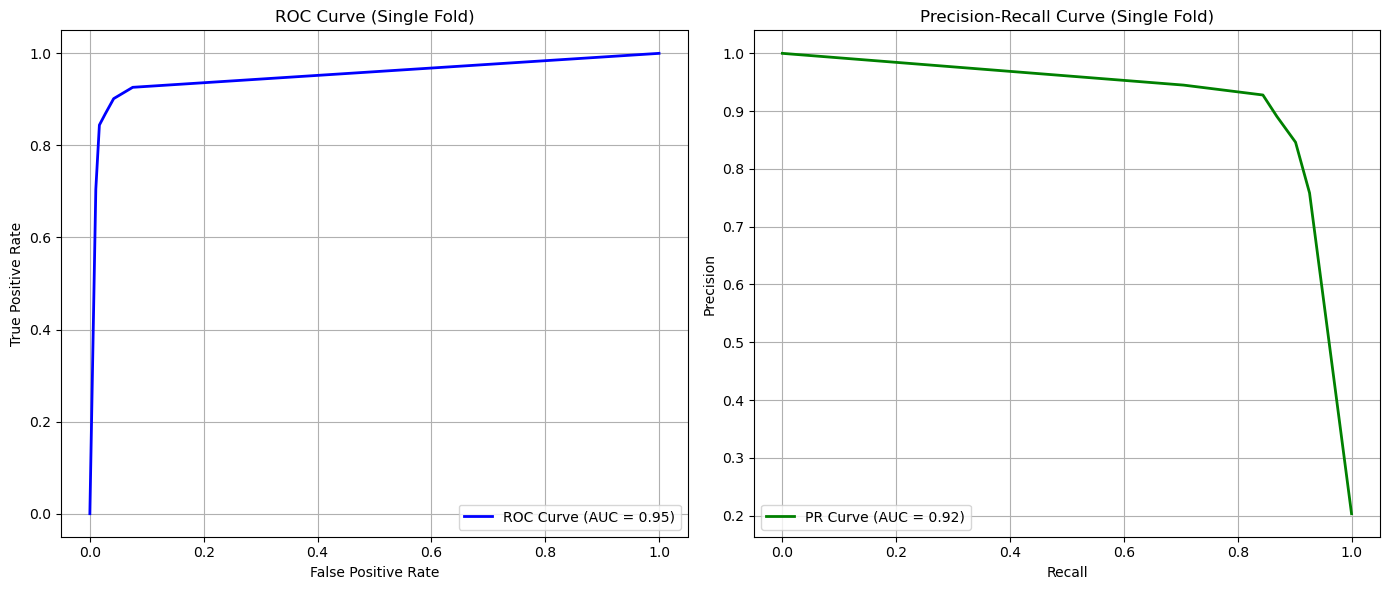

In [40]:
# Select a fold for visualization
fold_idx = 0  # the index to visualize a different fold

# Retrieve test labels and predicted probabilities from the stored results
y_test, y_proba = test_sets[fold_idx]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

# Plot ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve (Single Fold)")
axes[0].legend(loc="lower right")
axes[0].grid()

# PR Curve
axes[1].plot(recall, precision, color='green', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve (Single Fold)")
axes[1].legend(loc="lower left")
axes[1].grid()

plt.tight_layout()
plt.show()


### Discussion: 

The ROC curve is very steep near the origin, which suggests that the model is capable of capturing true positives while keeping false positives low.
    Furthermore the high AUC and small distance between the curve and the top left corner (0,1), suggests that this is a good classifier.


The PR curve is nearly a reflection of the ROC curve, which is impressive given the class imbalance (80/20). However, there is a fairly sharp drop in the curve, which shows the model has difficulty maintaining high precision as recall increases.

For this problem we are interested in the LHS of the ROC curve, because: 
- The dataset has class imbalance (80% -1, 20% +1), meaning false positives (FPR) must be minimized to avoid misclassifying too many negative examples.
- In imbalanced problems, a model with low false positive rate (FPR) but high true positive rate (TPR) is preferred, since excessive false positives will inflate the number of incorrect positive classifications.

# Question No. 3:  [20% Marks] Cross-validation of SVM and RFs

## Q3 i)

### Discussion: 

My strategy is to use randomized grid searches to tune the hyperparameters for both models, after which I will compare the run 5-fold stratified cross-validation over both models.

### Code:

In [49]:
# ---------------------- DATA PREPROCESSING ---------------------- #

# Standardize features for SVMs
scaler_svm = StandardScaler()
xtrain_svm = scaler_svm.fit_transform(xtrain)

# Normalize features for Random Forest
scaler_rf = MinMaxScaler()
xtrain_rf = scaler_rf.fit_transform(xtrain)

# Define Stratified 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

# ---------------------- HYPERPARAMETER OPTIMIZATION ---------------------- #

# SVM Parameter Grid
svm_params = {
    "C": [0.1, 1, 10],  
    "kernel": ["linear", "poly", "rbf"],  
    "degree": [2, 3, 4],  # Only for polynomial kernel
    "gamma": ["scale", "auto"]  # Only for rbf and poly kernels
}

# Random Forest Parameter Grid
rf_params = {
    "n_estimators": [50, 100, 200],  
    "max_depth": [None, 10, 20],  
    "min_samples_split": [2, 5, 10]
}

# Perform Randomized Search for SVM
start_time = time.time()
svm_random = RandomizedSearchCV(SVC(probability=True), svm_params, n_iter=30, cv=skf, scoring="balanced_accuracy", n_jobs=-1, random_state=21)
svm_random.fit(xtrain_svm, ytrain)
best_svm = svm_random.best_estimator_
print(f"SVM hyperparameter optimization took {time.time() - start_time:.2f} seconds")

# Perform Randomized Search for Random Forest
start_time = time.time()
rf_random = RandomizedSearchCV(RandomForestClassifier(random_state=21), rf_params, n_iter=27, cv=skf, scoring="balanced_accuracy", n_jobs=-1, random_state=21)
rf_random.fit(xtrain_rf, ytrain)
best_rf = rf_random.best_estimator_
print(f"Random Forest hyperparameter optimization took {time.time() - start_time:.2f} seconds")

print(f"Best SVM Hyperparameters: {svm_random.best_params_}")
print(f"Best RF Hyperparameters: {rf_random.best_params_}")

# ---------------------- 5-FOLD CROSS-VALIDATION ---------------------- #

# Store results for each classifier
results = {"SVM": {"Accuracy": [], "Balanced Accuracy": [], "AUC-ROC": [], "AUC-PR": []},
           "Random Forest": {"Accuracy": [], "Balanced Accuracy": [], "AUC-ROC": [], "AUC-PR": []}}

# Store ROC curve data for plotting
roc_curves = {}

# Perform cross-validation
start_time = time.time()
for train_idx, test_idx in skf.split(xtrain, ytrain):
    # Train/Test split for each classifier
    x_train_svm, x_test_svm = xtrain_svm[train_idx], xtrain_svm[test_idx]
    x_train_rf, x_test_rf = xtrain_rf[train_idx], xtrain_rf[test_idx]
    y_train, y_test = ytrain[train_idx], ytrain[test_idx]

    # Train and evaluate SVM
    best_svm.fit(x_train_svm, y_train)
    y_pred_svm = best_svm.predict(x_test_svm)
    y_proba_svm = best_svm.predict_proba(x_test_svm)[:, 1]

    results["SVM"]["Accuracy"].append(accuracy_score(y_test, y_pred_svm))
    results["SVM"]["Balanced Accuracy"].append(balanced_accuracy_score(y_test, y_pred_svm))
    results["SVM"]["AUC-ROC"].append(roc_auc_score(y_test, y_proba_svm))
    results["SVM"]["AUC-PR"].append(average_precision_score(y_test, y_proba_svm))

    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
    roc_curves["SVM"] = (fpr_svm, tpr_svm, auc(fpr_svm, tpr_svm))

    # Train and evaluate Random Forest
    best_rf.fit(x_train_rf, y_train)
    y_pred_rf = best_rf.predict(x_test_rf)
    y_proba_rf = best_rf.predict_proba(x_test_rf)[:, 1]

    results["Random Forest"]["Accuracy"].append(accuracy_score(y_test, y_pred_rf))
    results["Random Forest"]["Balanced Accuracy"].append(balanced_accuracy_score(y_test, y_pred_rf))
    results["Random Forest"]["AUC-ROC"].append(roc_auc_score(y_test, y_proba_rf))
    results["Random Forest"]["AUC-PR"].append(average_precision_score(y_test, y_proba_rf))

    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
    roc_curves["Random Forest"] = (fpr_rf, tpr_rf, auc(fpr_rf, tpr_rf))

print(f"Cross-Validation took {time.time() - start_time:.2f} seconds")

SVM hyperparameter optimization took 139.79 seconds
Random Forest hyperparameter optimization took 46.30 seconds
Best SVM Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 10}
Best RF Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 20}
Cross-Validation took 13.84 seconds


## Q3 ii)

In [51]:
# Convert results to DataFrame and compute mean/std
metrics_df = {clf: pd.DataFrame(results[clf]) for clf in results}
for clf in metrics_df:
    metrics_df[clf].loc["Mean"] = metrics_df[clf].mean()
    metrics_df[clf].loc["Std Dev"] = metrics_df[clf].std()

# Print results
print("\nSVM Performance:\n", metrics_df["SVM"])
print("\nRandom Forest Performance:\n", metrics_df["Random Forest"])


SVM Performance:
          Accuracy  Balanced Accuracy   AUC-ROC    AUC-PR
0        0.958333           0.934169  0.981892  0.963863
1        0.980000           0.972337  0.991853  0.988226
2        0.978333           0.962239  0.994989  0.981662
3        0.980000           0.975354  0.994767  0.975034
4        0.978333           0.968272  0.996796  0.989320
Mean     0.975000           0.962474  0.992059  0.979621
Std Dev  0.008367           0.014819  0.005325  0.009398

Random Forest Performance:
          Accuracy  Balanced Accuracy   AUC-ROC    AUC-PR
0        0.965000           0.932248  0.982921  0.962921
1        0.978333           0.965255  0.993216  0.980372
2        0.973333           0.950043  0.995458  0.984544
3        0.976667           0.952140  0.993975  0.980371
4        0.973333           0.956077  0.997034  0.989313
Mean     0.973333           0.951153  0.992521  0.979504
Std Dev  0.004595           0.010795  0.004975  0.008923


## Q3 iii)

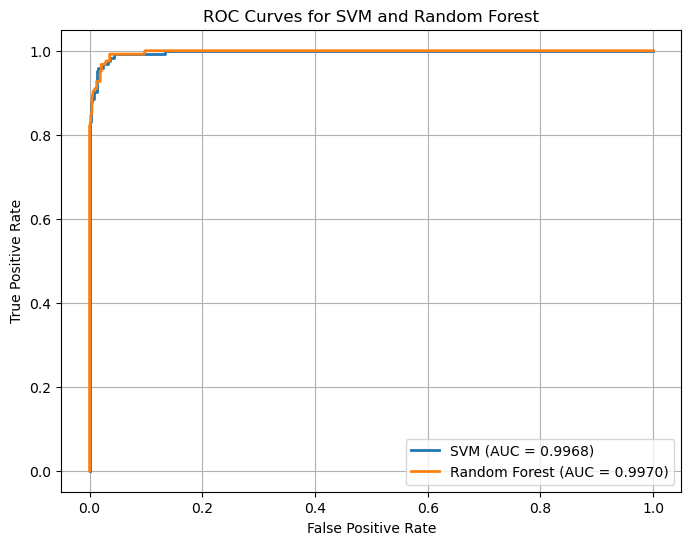

In [53]:
# ---------------------- PLOT ROC CURVES ---------------------- #

plt.figure(figsize=(8, 6))

for clf, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, lw=2, label=f"{clf} (AUC = {roc_auc:.4f})")


# Formatting
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for SVM and Random Forest")
plt.legend(loc="lower right")
plt.grid()

# Show plot
plt.show()

## Q3 iv)

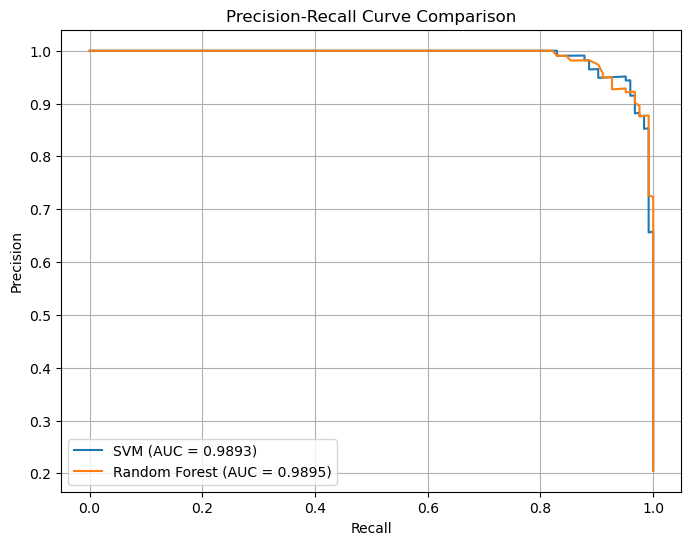

In [55]:
# ---------------------- PLOT PR CURVES ---------------------- #
plt.figure(figsize=(8, 6))

for clf_name, (fpr, tpr, roc_auc) in roc_curves.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba_svm if clf_name == "SVM" else y_proba_rf)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{clf_name} (AUC = {pr_auc:.4})")

# Formatting the plot
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid()
plt.show()


## Q3 v)

The AUC-ROC is very high for both classifiers, suggesting they are performing exceptionally.

However, there is a small drop (relative) in precision at high values of recall in both classifiers. This may cause problems given the current class imbalance.

# Question No. 4 [20% Marks] PCA

## Q4 i)

### Code:

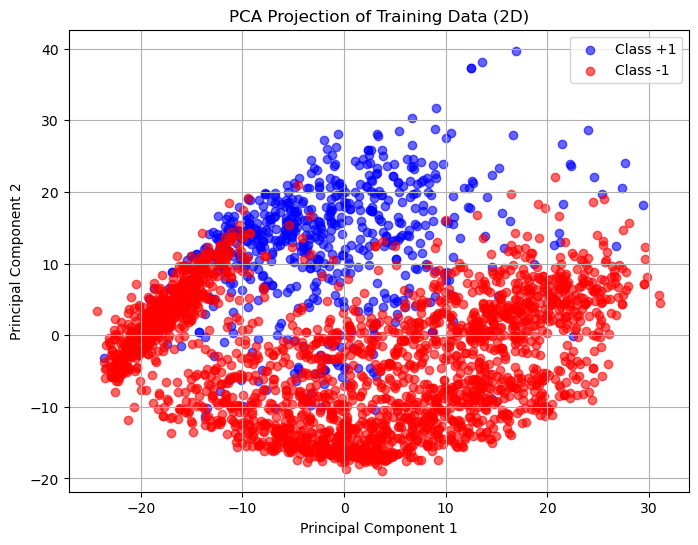

In [61]:
# Scale data before applying PCA
scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(xtrain)
Scaled_data=scaling.transform(xtrain)

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
xtrain_pca = pca.fit_transform(Scaled_data)  # Transform data to 2D

# Scatter plot of the PCA-reduced data
plt.figure(figsize=(8, 6))
plt.scatter(xtrain_pca[ytrain == 1, 0], xtrain_pca[ytrain == 1, 1], 
            color='blue', alpha=0.6, label="Class +1")
plt.scatter(xtrain_pca[ytrain == -1, 0], xtrain_pca[ytrain == -1, 1], 
            color='red', alpha=0.6, label="Class -1")

# Formatting
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Training Data (2D)")
plt.legend()
plt.grid()

# Show plot
plt.show()


### Observations:

There is significant overlapping between the classes, which suggests that the classes are not linearly seperable. This overlap also suggests that the training data is noisy, by which I mean it doesn't contain clear features or is mislabelled.

However this is still some seperation between the classes, which suggests that the features are too complex to be explained by two principal componenets. Perhaps PCA in higher dimesions would produce a cleaner seperation boundary.

## Q4 ii)

### Code:

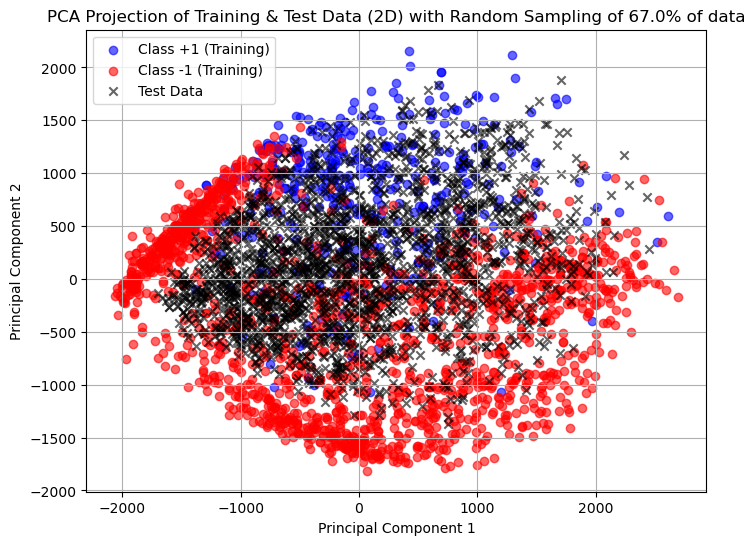

In [66]:
# Concatenate training and test data for joint PCA transformation
X_combined = np.vstack((xtrain, xtest))

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)  # Transform both datasets

# Split back into training and test sets
xtrain_pca = X_pca[:len(xtrain)]
xtest_pca = X_pca[len(xtrain):]

# Randomly sample half of each set
np.random.seed(21)  # Ensures reproducibility

# Proportion of points to sample
factor = 1.5

# Sample training points by class
class_1_indices = np.where(ytrain == 1)[0]
class_1_sample = np.random.choice(class_1_indices, size=int(len(class_1_indices) // factor), replace=False)

class_0_indices = np.where(ytrain == -1)[0]
class_0_sample = np.random.choice(class_0_indices, size=int(len(class_0_indices) // factor), replace=False)

# Sample test points
test_sample = np.random.choice(len(xtest_pca), size=int(len(xtest_pca) // factor), replace=False)

# Scatter plot
plt.figure(figsize=(8, 6))

# Training class +1 points (Blue)
plt.scatter(xtrain_pca[class_1_sample, 0], xtrain_pca[class_1_sample, 1], 
            color='blue', alpha=0.6, label="Class +1 (Training)", marker="o")

# Training class -1 points (Red)
plt.scatter(xtrain_pca[class_0_sample, 0], xtrain_pca[class_0_sample, 1], 
            color='red', alpha=0.6, label="Class -1 (Training)", marker="o")

# Test points (Black)
plt.scatter(xtest_pca[test_sample, 0], xtest_pca[test_sample, 1], 
            color='black', alpha=0.6, label="Test Data", marker="x")

# Formatting
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Training & Test Data (2D) with Random Sampling of "+str(round(1/factor,2)*100)+"% of data")
plt.legend()
plt.grid()

# Show plot
plt.show()


### Observations:

The test data seems to have the same general shape on the PCA plot, with nearly all test points ecclipsed by training points.

However, the distribution of test points looks biased in the direction of PC 2, which pushes it in similarity towards the +1 class in training data. Because of this, I would say that the test data is more similar to +1 class in training data. 

## Q4 iii)

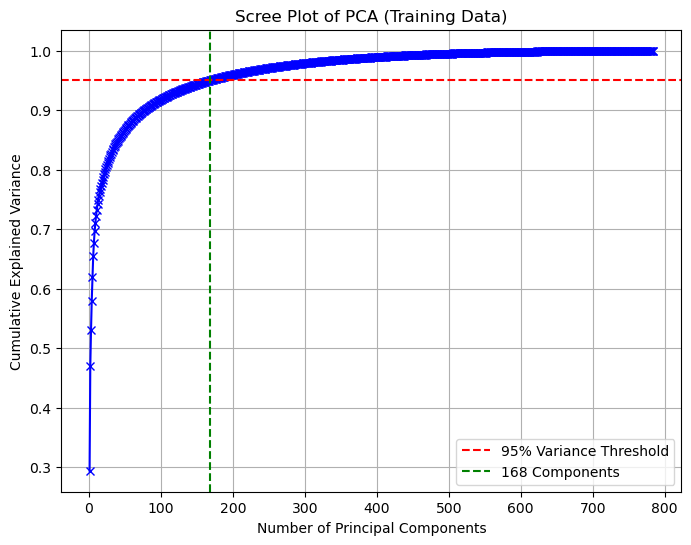

Number of principal components explaining 95% variance: 168


In [70]:
# Apply PCA to the training set
pca = PCA()
pca.fit(xtrain)  # Fit PCA on training data

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)  # Cumulative sum of explained variance

# Find number of components that explain 95% variance
num_components_95 = np.argmax(explained_variance >= 0.95) + 1

# Plot Scree Graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='x', linestyle='-', color='b')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance Threshold")
plt.axvline(x=num_components_95, color='g', linestyle='--', label=f"{num_components_95} Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot of PCA (Training Data)")
plt.legend()
plt.grid()

# Show plot
plt.show()

# Print number of components explaining 95% variance
print(f"Number of principal components explaining 95% variance: {num_components_95}")


## Q4 iv)

In [72]:
# ---------------------- APPLY PCA ---------------------- #

# Standardize features before PCA (SVM is sensitive to scaling)
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)

start_time = time.time()
# Apply PCA with 168 components (or modify this number for experimentation)
pca168 = PCA(n_components=168)
xtrain_pca = pca168.fit_transform(xtrain_scaled)
end_time = time.time()
print(f"PCA taken: {end_time - start_time:.2f} seconds")

# ---------------------- HYPERPARAMETER OPTIMIZATION ---------------------- #

# Define parameter grid for Kernelized SVM
svm_params = {
    "C": [1, 10, 100],  # Regularization strength
    "kernel": ["rbf", "poly"],  # Choosing RBF and Polynomial
    "degree": [2, 3, 4],  # Only applies to poly kernel
    "gamma": ["scale", "auto"]  # Kernel coefficient
}

# Perform Grid Search with 5-fold Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
svm = SVC(probability=True)  # Enable probability estimates for AUC computation

"""
svm_grid = GridSearchCV(svm, svm_params, cv=skf, scoring="balanced_accuracy", n_jobs=-1)
svm_grid.fit(xtrain_pca, ytrain)
"""
start_time = time.time()
svm_random = RandomizedSearchCV(
    svm, svm_params, n_iter=30, cv=skf, scoring="balanced_accuracy", n_jobs=-1, random_state=21
)
svm_random.fit(xtrain_pca, ytrain)
end_time = time.time()
print(f"Randomized Grid Search Time Taken: {end_time - start_time:.2f} seconds")

# Best SVM model after hyperparameter tuning
best_svm_pcad = svm_random.best_estimator_
print(f"Best SVM Hyperparameters: {svm_random.best_params_}")

# ---------------------- 5-FOLD CROSS-VALIDATION ---------------------- #

# Cross-validation results storage
metrics = {"Balanced Accuracy": [], "AUC-ROC": [], "AUC-PR": []}

start_time = time.time()
for train_idx, test_idx in skf.split(xtrain_pca, ytrain):
    x_train, x_test = xtrain_pca[train_idx], xtrain_pca[test_idx]
    y_train, y_test = ytrain[train_idx], ytrain[test_idx]

    # Train the best SVM model
    best_svm_pcad.fit(x_train, y_train)

    # Make predictions
    y_pred = best_svm_pcad.predict(x_test)
    y_proba = best_svm_pcad.predict_proba(x_test)[:, 1]  # Probabilities for class +1

    # Compute metrics
    metrics["Balanced Accuracy"].append(balanced_accuracy_score(y_test, y_pred))
    metrics["AUC-ROC"].append(roc_auc_score(y_test, y_proba))
    metrics["AUC-PR"].append(average_precision_score(y_test, y_proba))
end_time = time.time()
print(f"Cross-Validation Time Taken: {end_time - start_time:.2f} seconds")


# Convert results to DataFrame
metrics_df = pd.DataFrame(metrics)

# Compute mean and standard deviation
metrics_df.loc["Mean"] = metrics_df.mean()
metrics_df.loc["Std Dev"] = metrics_df.std()

# Display performance metrics
print("\nCross-Validation Performance of Kernelized SVM with PCA:")
print(metrics_df)


PCA taken: 0.20 seconds
Randomized Grid Search Time Taken: 34.23 seconds
Best SVM Hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 10}
Cross-Validation Time Taken: 2.16 seconds

Cross-Validation Performance of Kernelized SVM with PCA:
         Balanced Accuracy   AUC-ROC    AUC-PR
0                 0.943412  0.983538  0.968260
1                 0.973385  0.992824  0.989896
2                 0.962239  0.994870  0.982886
3                 0.974306  0.994358  0.973654
4                 0.970241  0.994972  0.988023
Mean              0.964717  0.992112  0.980544
Std Dev           0.011469  0.004356  0.008334


The optimal cross-validation performance, with the data reduced to 168 dimensions, is a balanced accuracy of 0.959.

# Question No. 5 Optimal Pipeline [20% Marks]

## Discussion:

*This pipeline trains a Random Forest classifier (RF) on the training data and generates probability scores for test images*

1. **My Initial Thought Process**
- Initially, the best classifier from Questions 3 and 4 was identified as an SVM, which had already been tuned.
- The intention was to use SVM with the fixed hyperparameters.
However, there was an issue: SVM’s probability estimates were highly skewed.


2. **Issues with Using SVM for Probability Estimates**
 
SVM does not natively provide probability estimates. Instead, it uses Platt scaling, which:

- Fits a logistic regression model to the decision function outputs.
- Distorts probability estimates when:
    - The dataset is imbalanced.
    - The decision function outputs are far from the margin.
    - The training data is not well-calibrated for probability estimation.
  
This led to the SVM assigning nearly the same probability score for basically all images, making it ineffective for this problem.

3. **Switching to Random Forest**
- To fix this issue, a Random Forest classifier (RF) was used instead.
- RF has an inherent probabilistic nature, as it:
    - Aggregates results from multiple decision trees.
    - Outputs probabilities naturally by averaging tree votes.
  
This immediately resolved the probability skewing issue.


## Code: 

In [78]:
def optimal_pipeline(xtest_filename):
    # Define the Random Forest model with fixed hyperparameters
    best_rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, max_depth=20, random_state=21)
    
    # Train the model on the entire training set
    start_time = time.time()
    best_rf.fit(xtrain, ytrain)  # No scaling
    end_time = time.time()
    print(f"Model Training Time Taken: {end_time - start_time:.2f} seconds")
    
    # Load test data
    xtest = np.loadtxt(xtest_filename, delimiter=" ")
    
    # Predict probabilities for xtest (No scaling applied)
    y_pred = best_rf.predict_proba(xtest)[:, 1]
    
    # Write predicted probabilities to file, line by line
    output_filename = "u2104970.csv"
    np.savetxt(output_filename, y_pred, fmt="%.6f")
    
    print(f"Predictions saved to {output_filename}")

# Run the optimal pipeline
optimal_pipeline("Xtest.csv")


Model Training Time Taken: 1.77 seconds
Predictions saved to u2104970.csv


Number of images predicted to be in class +1 : 1061
Mean predicted probability: 0.4611


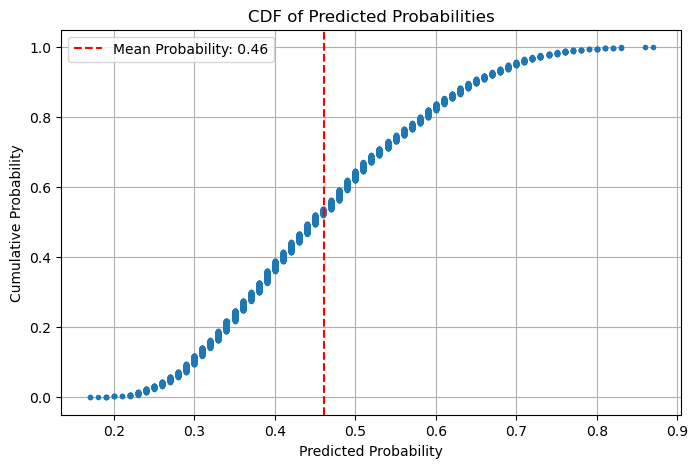

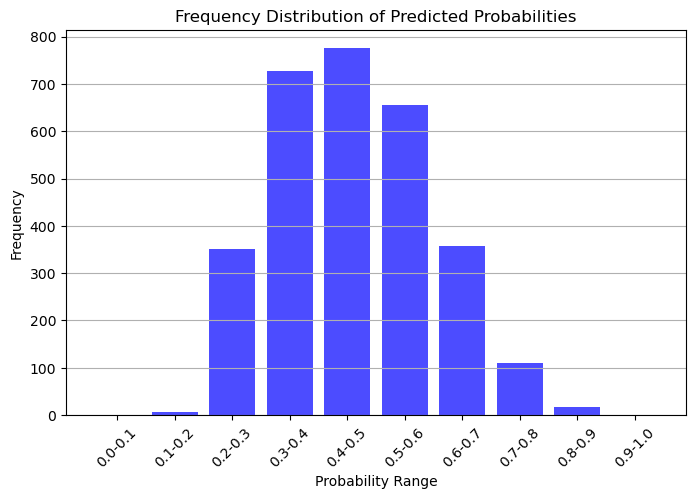

In [79]:
# Load predicted probabilities from file
y_pred = np.loadtxt("u2104970.csv", dtype=float)

# Count number of predictions with probability > 0.5
count_above_0_5 = np.sum(y_pred > 0.5)

# Print the result
print(f"Number of images predicted to be in class +1 : {count_above_0_5}")

# Compute mean probability
mean_prob = np.mean(y_pred)
print(f"Mean predicted probability: {mean_prob:.4f}")

# Compute and plot the CDF
sorted_probs = np.sort(y_pred)
cdf = np.arange(1, len(sorted_probs) + 1) / len(sorted_probs)

plt.figure(figsize=(8, 5))
plt.plot(sorted_probs, cdf, marker='.', linestyle='none')
plt.axvline(mean_prob, color='r', linestyle='dashed', label=f'Mean Probability: {mean_prob:.2f}')
plt.xlabel("Predicted Probability")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Predicted Probabilities")
plt.legend()
plt.grid()
plt.show()

# Create frequency table for probability bins
bins = np.arange(0, 1.1, 0.1)  # Define bins from 0 to 1 in steps of 0.1
bin_labels = [f"{round(bins[i], 1)}-{round(bins[i+1], 1)}" for i in range(len(bins)-1)]
counts, _ = np.histogram(y_pred, bins=bins)


# Plot the frequency distribution
plt.figure(figsize=(8, 5))
plt.bar(bin_labels, counts, color='blue', alpha=0.7)
plt.xlabel("Probability Range")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Predicted Probabilities")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Question No. 6 Another classification problem [20% Marks]

Task : predict whether data is in training or in test data

steps:
- first re-label the data, -1 if in the training test, +1 if in the test set
- build both a svm and rf, tune the hyper parameters for both
- select the one with most balanced accuracy after 5-fold cross validation
- report the average and sd of AUC-ROC after the 5-fold cross validation

## Q6 i)

### Discussion: 

An AUC-ROC value of 1.0 means that the classifier is perfectly separating the training and test sets.

This perfect separation suggests that there are systematic differences between training and test sets that the classifier is exploiting. This could be due to:

- Different preprocessing techniques (e.g. different contrast adjustments, resizing methods)
- Different sources of images (e.g. training and test images come from different datasets)
- Artifacts present in one set but not the other (e.g. differences in noise levels)

Furthermore, we notice that the standard deviation of AUC-ROC was 0 across all 5 folds in cross validation. This suggests that the Classifier is exploiting dataset artifacts, not learning general features:
- If the classifier was learning generalizable features, we would expect some variation in AUC-ROC across different folds of cross-validation.
- Since standard deviation is 0, it means that the differences are so strong and consistent that the classifier never misclassifies a sample, regardless of how the data is split.


### Code:

In [86]:
# Create a new label for distinguishing between training and test data
y_train_alternate = np.full(len(xtrain), -1)  # Train set labeled as -1
y_test_alternate = np.full(len(xtest), 1)    # Test set labeled as +1

# Concatenate train and test data
X_combined = np.vstack((xtrain, xtest))
y_combined = np.concatenate((y_train_alternate, y_test_alternate))

# Standardize features
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

# Define parameter grid for SVM
svm_params = {
    "C": [1, 10, 100],
    "kernel": ["rbf", "poly"],
    "degree": [2, 3, 4],
    "gamma": ["scale", "auto"]
}

# Perform Randomized Search with 5-fold Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
svm = SVC(probability=True)

start_time = time.time()
svm_random = RandomizedSearchCV(
    svm, svm_params, n_iter=20, cv=skf, scoring="balanced_accuracy", n_jobs=-1, random_state=21
)
svm_random.fit(X_combined_scaled, y_combined)
end_time = time.time()
print(f"Randomized Grid Search Time Taken: {end_time - start_time:.2f} seconds")

# Best SVM model after hyperparameter tuning
best_svm = svm_random.best_estimator_
print(f"Best SVM Hyperparameters: {svm_random.best_params_}")

# Compute AUC-ROC across 5-fold CV
auc_scores = []
start_time = time.time()
for train_idx, test_idx in skf.split(X_combined_scaled, y_combined):
    X_train, X_test = X_combined_scaled[train_idx], X_combined_scaled[test_idx]
    y_train, y_test = y_combined[train_idx], y_combined[test_idx]
    
    best_svm.fit(X_train, y_train)
    y_proba = best_svm.predict_proba(X_test)[:, 1]
    auc_scores.append(roc_auc_score(y_test, y_proba))
end_time = time.time()
print(f"Cross-Validation Time Taken: {end_time - start_time:.2f} seconds")

# Compute mean and standard deviation of AUC-ROC
auc_mean = np.mean(auc_scores)
auc_std = np.std(auc_scores)

print(f"Mean AUC-ROC: {auc_mean:.4f}")
print(f"Standard Deviation of AUC-ROC: {auc_std:.4f}")


Randomized Grid Search Time Taken: 551.40 seconds
Best SVM Hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 100}
Cross-Validation Time Taken: 38.85 seconds
Mean AUC-ROC: 1.0000
Standard Deviation of AUC-ROC: 0.0000


## Q6 ii)

### Code:

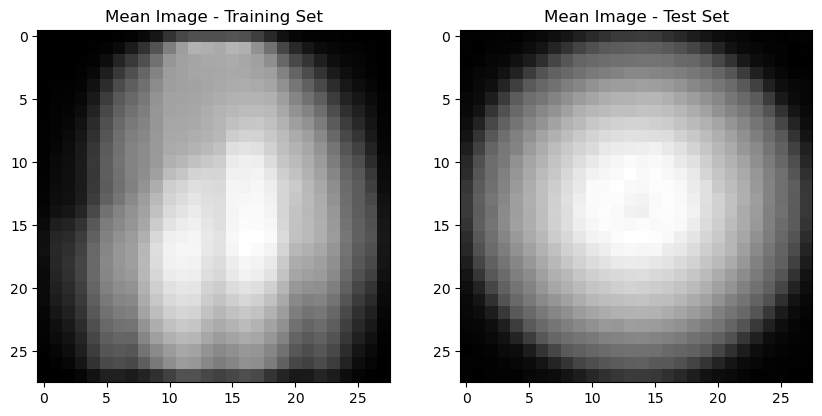

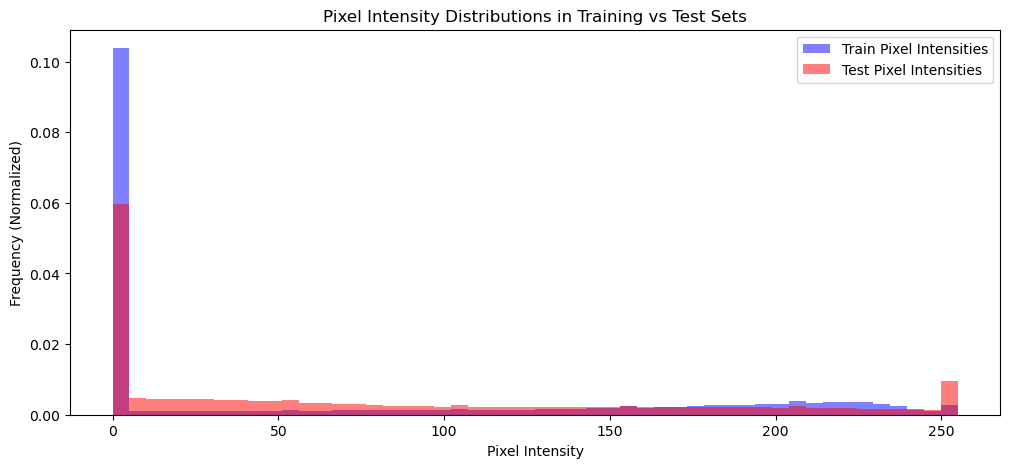

In [118]:
# ---------------- IMAGE COMPARISON ANALYSIS ---------------- #

# Compute mean images for both datasets
train_mean_img = np.mean(xtrain, axis=0).reshape(28, 28)
test_mean_img = np.mean(xtest, axis=0).reshape(28, 28)

# Plot Mean Images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(train_mean_img, cmap='gray')
axs[0].set_title("Mean Image - Training Set")
axs[1].imshow(test_mean_img, cmap='gray')
axs[1].set_title("Mean Image - Test Set")
plt.show()

# Plot pixel intensity distributions
plt.figure(figsize=(12, 5))
plt.hist(xtrain.flatten(), bins=50, alpha=0.5, label='Train Pixel Intensities', color='blue', density=True)
plt.hist(xtest.flatten(), bins=50, alpha=0.5, label='Test Pixel Intensities', color='red', density=True)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency (Normalized)")
plt.legend()
plt.title("Pixel Intensity Distributions in Training vs Test Sets")
plt.show()



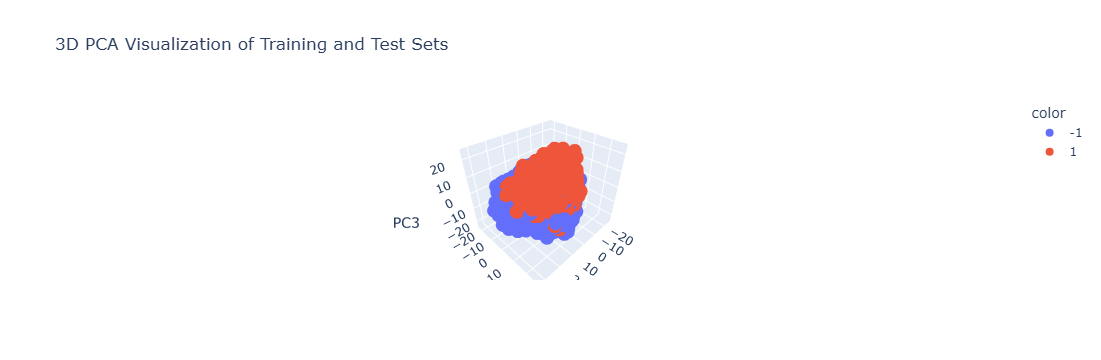

In [89]:
# Create a new label for distinguishing between training and test data
y_train_alternate = np.full(len(xtrain), -1)  # Train set labeled as -1
y_test_alternate = np.full(len(xtest), 1)    # Test set labeled as +1

# Concatenate train and test data
X_combined = np.vstack((xtrain, xtest))
y_combined = np.concatenate((y_train_alternate, y_test_alternate))

# Standardize features
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

# Apply PCA to reduce dimensions to 3 for visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_combined_scaled)

# Convert to DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca['Label'] = y_combined

# Create interactive 3D scatter plot
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color=df_pca['Label'].astype(str),
                     title='3D PCA Visualization of Training and Test Sets')
fig.show()


### Discussion:

**1) Mean Image Analysis: Detecting Rotation and Structural Differences**

By computing the average pixel intensity for training and test sets, we noticed:

- The training set mean image had a clear vertically aligned structure, suggesting that the training images were mostly upright.
- The test set mean image formed a near-perfect circle, indicating that test images had been randomly rotated
- This means the classifier could exploit orientation differences, rather than learning meaningful object features.

**FIX:**
- Apply random rotations to training images to make them match the test distribution.
- Ensure that both training and test images have a similar range of orientations.

**2) Pixel Intensity Distributions: Detecting Preprocessing Differences**
   
By plotting histograms of pixel values across the training and test sets, we found:

- The training pixel intensity distribution was broader and more spread out, indicating higher contrast and sharper features.
- The test pixel intensity distribution was narrower and more concentrated, suggesting blurring or different contrast adjustments.

**FIX:**
- Apply Gaussian blur to training images to introduce similar levels of blurring in training images to balance the distributions.
- Normalize contrast across both sets, using histogram equalization to align intensity distributions

## Q6 iii)

In [93]:
# Function to apply random noise and rotation
def augment_images(images, noise_level=50, max_rotation=180):
    augmented_images = []
    for img in images:
        img = img.reshape(28, 28)
        
        # Add random Gaussian noise
        noise = np.random.normal(0, noise_level, img.shape)
        img_noisy = np.clip(img + noise, 0, 255)
        
        # Apply random rotation
        angle = np.random.uniform(-max_rotation, max_rotation)
        img_rotated = rotate(img_noisy, angle, reshape=False, mode='nearest')
        
        augmented_images.append(img_rotated.flatten())
    return np.array(augmented_images)

# Apply augmentations to training set
xtrain_augmented = augment_images(xtrain)

# Create new labels for distinguishing between training and test data
y_train_alternate = np.full(len(xtrain_augmented), -1)  # Train set labeled as -1
y_test_alternate = np.full(len(xtest), 1)    # Test set labeled as +1

# Concatenate train and test data
X_combined = np.vstack((xtrain_augmented, xtest))
y_combined = np.concatenate((y_train_alternate, y_test_alternate))

# Standardize features
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

# Define SVM with fixed hyperparameters
best_svm = SVC(C=10, kernel="rbf", gamma="scale", degree=3, probability=True)

# Train and evaluate the model
auc_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

start_time = time.time()
for train_idx, test_idx in skf.split(X_combined_scaled, y_combined):
    X_train, X_test = X_combined_scaled[train_idx], X_combined_scaled[test_idx]
    y_train, y_test = y_combined[train_idx], y_combined[test_idx]
    
    best_svm.fit(X_train, y_train)
    y_proba = best_svm.predict_proba(X_test)[:, 1]
    auc_scores.append(roc_auc_score(y_test, y_proba))
end_time = time.time()
print(f"Cross-Validation Time Taken: {end_time - start_time:.2f} seconds")

# Compute mean and standard deviation of AUC-ROC
auc_mean = np.mean(auc_scores)
auc_std = np.std(auc_scores)

print(f"Mean AUC-ROC after augmentation: {auc_mean:.4f}")
print(f"Standard Deviation of AUC-ROC after augmentation: {auc_std:.4f}")

Cross-Validation Time Taken: 175.44 seconds
Mean AUC-ROC after augmentation: 0.8611
Standard Deviation of AUC-ROC after augmentation: 0.0079


The AUC-ROC has dropped from 1.00 to 0.8611, which suggests that the augmented training is now more similar to the original test data. Considering that they likely came from a similar distribution, this implies that the test data likely underwent transformations that were absent in the original training set, specifically blurring and random rotations.

The issues of rotation had been identified at the beginning of this assignent in Q1)ii) when visualizing the test data. This was confirmed when comparing the mean image for the original training vs test data:

- The mean image for the training set maintained a vertically aligned structure, suggesting that the training images had a consistent orientation.

- The mean image for the test set, however, formed a near-perfect circle, indicating that the test images were randomly rotated.
  
- This suggests that the test images underwent random rotations, likely as part of their preprocessing or generation process.

- Since the original training set did not include these rotations, the classifier was able to exploit these differences to perfectly separate training from test data (AUC-ROC = 1.00).

Similarly, the issue of blurring had been identified early on when visualising the test images:
- The test images appeared more blurred compared to the training images, indicating that they had undergone smoothing (possibly due to preprocessing).
  
- To counteract this, we added random Gaussian noise to the training images.
  
- This mimics blurring by reducing sharpness and contrast, bringing the training images closer in appearance to the test images.
  
- As a result, the classifier now struggles more to separate training from test data, further contributing to the drop in AUC-ROC from 1.00 to 0.8611.